# AUTO-MPG with KERAS

              mpg   cylinders  ...        year      origin
count  398.000000  398.000000  ...  398.000000  398.000000
mean    23.514573    5.454774  ...   76.010050    1.572864
std      7.815984    1.701004  ...    3.697627    0.802055
min      9.000000    3.000000  ...   70.000000    1.000000
25%     17.500000    4.000000  ...   73.000000    1.000000
50%     23.000000    4.000000  ...   76.000000    1.000000
75%     29.000000    8.000000  ...   79.000000    2.000000
max     46.600000    8.000000  ...   82.000000    3.000000

[8 rows x 8 columns]
Shape of X = (7, 398), Shape of y_true = (398,)
X_train Shape : (298, 7)
X_valid Shape : (100, 7)
y_train Shape : (298,)
y_valid Shape : (100,)
Restoring model weights from the end of the best epoch.
Epoch 02918: early stopping


,loss,val_loss
2913,11.355540,10.430831
2914,11.355574,10.430092
2915,11.357603,10.428924
2916,11.354419,10.428479
2917,11.354392,10.430971


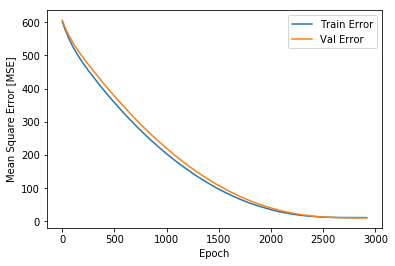

Layer 0 :
[array([[-0.59518605],
       [ 0.85252076],
       [-0.8305921 ],
       [-4.567389  ],
       [-0.21844646],
       [ 2.700055  ],
       [ 1.2221081 ]], dtype=float32), array([23.324928], dtype=float32)]
Layer 1 :


IndexError: ignored

In [0]:
import numpy as np 
import pandas as pd

# Imports for Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics



class standardizer:
  def __init__(self):
      self.row_scale_params = []
      
  def standardize(self, matrix):
    N = matrix.shape[0]
    result = np.empty( matrix.shape )    
    # run through the lines
    for i in range( N ):
      row = matrix[i,:]

      # Compute scaling parameters...
      mean = np.mean(row)
      std = np.std(row)

      # Handle std = 0 case
      if std < 1E-6:
        std = 1

      # and save
      self.row_scale_params.append( [mean, std] )
           
      # add the row to the output
      result[i, :] = np.array( (row - mean) / std  )

    return result

  def check(self, matrix):
    N = matrix.shape[0]
   
    for i in range( N ):
      row = matrix[i,:]

      # Compute scaling parameters...
      mean = np.mean(row)
      std = np.std(row)
      print(f"Row {i} : Mean = {mean}, Std = {std}")


def load_auto_mpg_data():
  df = pd.read_csv(
      "https://data.heatonresearch.com/data/t81-558/auto-mpg.csv", 
      na_values=['NA', '?'])
  
  print( df.describe() )

  # Handle the missing values
  df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())

  nCyl = df['cylinders']
  nDis = df['displacement']
  nHor = df['horsepower']
  nWei = df['weight']
  nAcc = df['acceleration']
  nYea = df['year']
  nOri = df['origin']

  X = pd.concat( [nCyl, nDis, nHor, nWei, nAcc, nYea, nOri], axis = 'columns').values;
  y_true =  df['mpg'].values  # changed, as keras needs only one vector

  # Note: We changed result, as KERAS needs features-vectors in rows, not in cols
  print(f"Shape of X = {X.T.shape}, Shape of y_true = {y_true.shape}")
  return (X.T, y_true)

(X, y_true) = load_auto_mpg_data()

standardizer = standardizer()
X_S = standardizer.standardize( X )

# As before: split test and train data
X_train, X_valid, y_train, y_valid = train_test_split(    
    X_S.T, y_true, test_size=0.25, random_state=43)

#Check the shapes
print(f"X_train Shape : {X_train.shape}")
print(f"X_valid Shape : {X_valid.shape}")
print(f"y_train Shape : {y_train.shape}")
print(f"y_valid Shape : {y_valid.shape}")

# Build Early Stop Monitor
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto',
        restore_best_weights=True)

# Build the neural network
input_dimension = X_train.shape[1] # note the difference to our network
model = Sequential()
model.add(Dense(1, input_dim=input_dimension, activation='linear')) # Hidden 1
#model.add(Dense(4, activation='relu')) # Hidden 2
#model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')

# Run the training
history = model.fit(X_train,y_train,validation_data=(X_valid, y_valid), verbose=0,callbacks=[monitor], epochs=10000)

# Display losses
hist = pd.DataFrame(history.history)
display( hist.tail( 5 ) )
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [MSE]')
plt.plot(history.epoch, hist['loss'],
           label='Train Error')
plt.plot(hist['val_loss'],
           label = 'Val Error')
#plt.ylim([0,50])
plt.legend()
plt.show()

# We display the weighst and biases
print("Layer 0 :")
print( model.layers[0].get_weights())   

print("Layer 1 :")
print( model.layers[1].get_weights())   

